# **Reference**
**아래 코드는 https://github.com/lukemelas/Automatic-Image-Colorization/ 의 코드를 바탕으로하여 만든 코드입니다.**

# **0. Basics**
해당 코드를 돌리기 위한 기본적인 사항들 입니다.

(Ex : import module, 구글드라이브 마운트, 변수선언, 유용한 함수선언 등)

In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time, sys
# Too ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_losses = 1e+6 # lowest validation loss
current_epoch = 0  # start from epoch 0 or last checkpoint epoch
iteration = 0 # number of iteration
train_loss_list = [] # training loss list
val_loss_list = [] # validation loss list
lr_list = [] # learning rate list
img_list = [] # training img list
if torch.cuda.is_available():
  print("현재 사용중인 GPU : {}".format(torch.cuda.get_device_name(0)))
else:
  print("현재 GPU를 사용하고 있지 않습니다.")

현재 사용중인 GPU : GeForce GTX 1060 6GB


In [2]:
# 구글 드라이브 마운트 - 이하 코드는 구글 코랩에서 작업하기 위한 코드들입니다. 로컬에서 작업하실거면 무시하셔도 됩니다.
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/딥러닝의 기초/Project")
sys.path.append('/content/drive/My Drive/Colab Notebooks/딥러닝의 기초/Project')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input):
    '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 1) # combine channels
    #color_image[:, :, 0:1] = color_image[:, :, 0:1]
    #color_image[:, :, 1:3] = color_image[:, :, 1:3]

    for i in range(0, len(color_image)):
        color_image[i] = torch.from_numpy(lab2rgb(color_image[i].permute(1, 2, 0).numpy())).permute(2, 0, 1)
    grayscale_input = grayscale_input.squeeze().numpy()
    
    return color_image

# **1. Loading dataset**

## 1.1 Custom Dataset

지정된 경로에 있는 모든 이미지를 갖고있는 객체를 만드는 클래스입니다. 예를들어



```
train_imagefolder = GrayscaleImageFolder('./dataset/train/', train_transforms)
```

위 코드는 './dataset/train/(아무폴더)'디렉토리에 있는 모든 이미지를 모은 객체를 생성합니다.

이때 우리가 불러오고자하는 이미지들은 반드시 train폴더가 아닌 train폴더안의 (아무폴더)에 들어있어야 합니다.


한편 transforms는 Data augmentation을 적용하기 위한 argument입니다. 


```
train_imagefolder[idx]
```
위 코드는 해당 객체의 idx번째 이미지로부터 (Grayscale된 이미지), (ab 이미지), (원본 이미지)를 반환합니다.



In [3]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
        img = self.transform(img)
    img = np.asarray(img)
    img_lab = rgb2lab(img)
    img_ab = img_lab[:, :, 1:3]
    img_ab = torch.from_numpy(img_ab).float().permute(2, 0, 1)
    # 2 * 256 * 256
    img_gray = img_lab[:, :, 0]
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    # 1 * 256 * 256
    if self.target_transform is not None:
        target = self.target_transform(target)
    return img_gray, img_ab, img

## 1.2 Data Augmentation & Loading

Data Augmentation(데이터 증강)을 적용하고 데이터를 로드하는 코드입니다. 
Data Augmentation은 transform_augmentation을 수정하여 바꿀 수 있습니다. 예를들어



```
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip()])
```
위 코드는

(1) 원본 이미지에서 256 * 256 만큼 Randomcrop하고

(2) 일정확률로 위 아래를 뒤집기

하는 역할을 합니다.

Pytorch에서 기본적으로 지원하는 Augmentation 기법들은 https://pytorch.org/docs/stable/torchvision/transforms.html 에서 확인할 수 있습니다.

In [4]:
# Training
print('Loading Training data...', end=' ')
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(1.0, 1.0)),
    transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('../dataset/flower102/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=16, shuffle=True)
print("Done!")
print("Training data size : {}".format(len(train_imagefolder)))

# Validation 
print('Loading Validation data...', end=' ')
val_transforms = transforms.Compose([
    transforms.Resize((256,256)),])
val_imagefolder = GrayscaleImageFolder('../dataset/flower102/val', val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=16, shuffle=False)
print("Done!")
print("Training data size : {}".format(len(val_imagefolder)))

Loading Training data... Done!
Training data size : 6552
Loading Validation data... Done!
Training data size : 818


## 1.3 Dataset Test

Dataset이 성공적으로 만들어졌는지 확인하는 코드입니다.

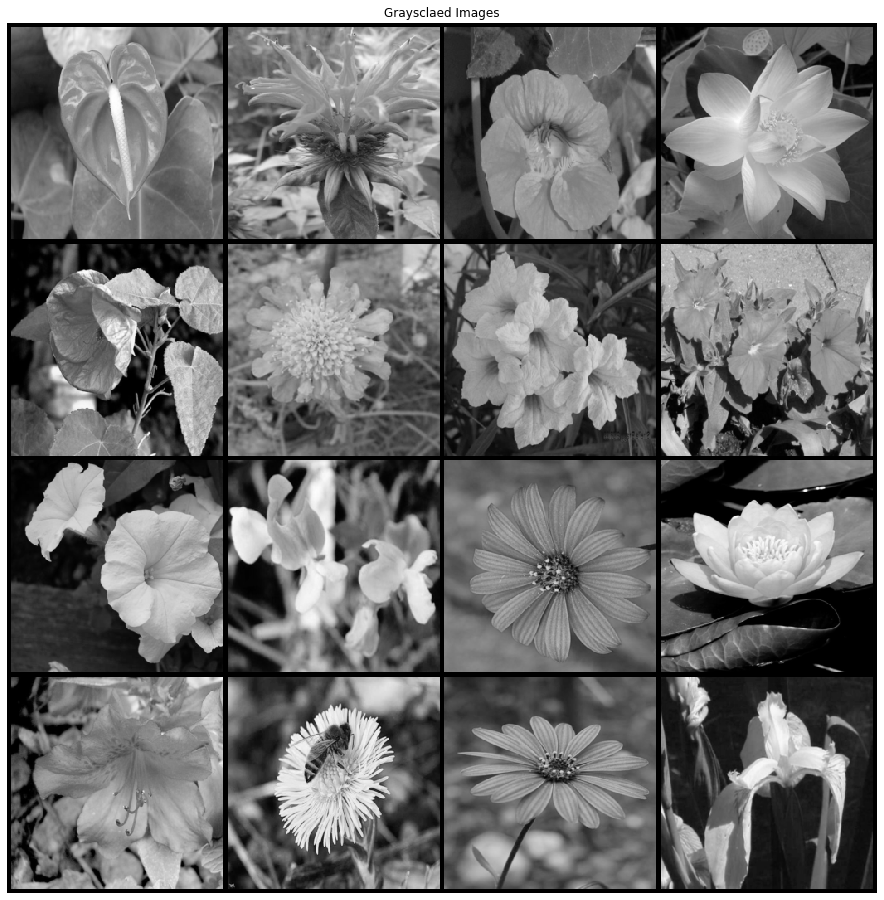

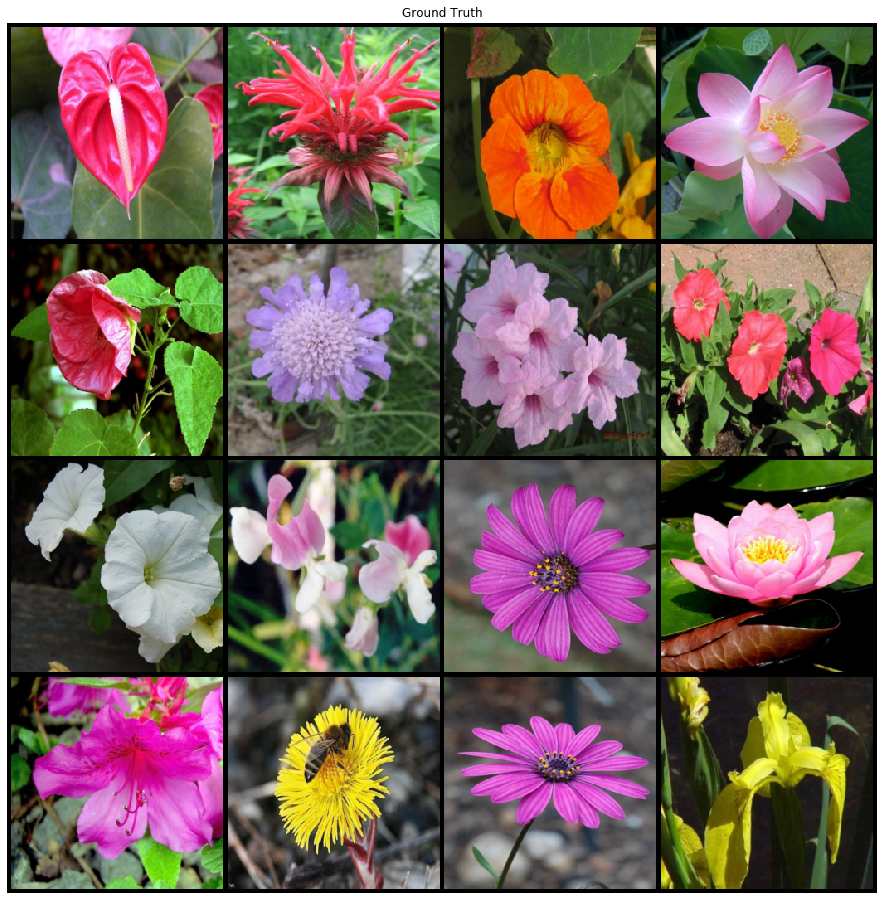

In [5]:
import random
# Plot some training images
real_batch = next(iter(train_loader))

plt.figure(figsize=(16, 16))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], nrow=4, padding=5, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Graysclaed Images")
plt.show()

plt.figure(figsize=(16, 16))
plt.imshow(vutils.make_grid(to_rgb(real_batch[0], real_batch[1])[:16], nrow=4, padding=5, normalize=True).cpu().permute(1,2,0))
plt.axis("off")
plt.title("Ground Truth")

plt.show()

# **2. Construct the Model**

학습에 쓸 모델에 해당하는 코드입니다.

현재 프로토타입으로 쓰인 모델은 (인풋)-(인코더)-(디코더)-(아웃풋)으로 구성되어 있습니다.

인풋은 Grayscaled Image를 나타내는 1 * 256 * 256 의 Tensor입니다.

인코더는 1개 채널의 Input Tensor를 512개 채널을 가진 Feature Tensor로 변환하며 이 모델에서는 Resnet18을 사용하였습니다.

참고로 인코더가 Feature 추출을 더 잘하기 위해서, 먼저 Flower102 데이터셋에 대한 분류기로 Pre-train시켰습니다. 
(Validation Accuracy 89.120%)

디코더는 Feature Tensor를 다시 2 * 256 * 256 의 Output Tensor로 변환하며 Convolutional Layer와 Upsampling Layer로 구성되어있습니다.

In [6]:
# Resnet
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        #print(x1.size())
        x2 = self.maxpool(x1)
        x2 = self.layer1(x2)
        #print(x2.size())
        x3 = self.layer2(x2)
        #print(x3.size())
        x4 = self.layer3(x3)
        #print(x4.size())
        x5 = self.layer4(x4)
        #print(x5.size())
        return (x5, x4, x3, x2, x1)

    # Allow for accessing forward method in a inherited class
    forward = _forward


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

## 2.1 ColorizationNet

Input이 통과할 전체 모델입니다.

(Reference : https://github.com/harshitbansal05/Image-Colorization/blob/master/model.py)

In [7]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        class Encoder(nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                # Build ResNet and change first conv layer to accept single-channel input
                self.resnet = resnet50()
                self.resnet.conv1.weight = nn.Parameter(self.resnet.conv1.weight.sum(dim=1).unsqueeze(1).data)

            def forward(self, input_image):
                # Pass input through ResNet-gray to extract features
                output = self.resnet(input_image)
                return output

        class Decoder(nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
                # Fusion layer to combine midlevel and global features

                # Convolutional layers and upsampling
                self.conv1 = nn.Conv2d(3072, 768, kernel_size=3, stride=1, padding=1)
                self.bn1 = nn.BatchNorm2d(768)
                self.conv2 = nn.Conv2d(1280, 320, kernel_size=3, stride=1, padding=1)
                self.bn2 = nn.BatchNorm2d(320)
                self.conv3 = nn.Conv2d(576, 144, kernel_size=3, stride=1, padding=1)
                self.bn3 = nn.BatchNorm2d(144)
                self.conv4 = nn.Conv2d(208, 52, kernel_size=3, stride=1, padding=1)
                self.bn4 = nn.BatchNorm2d(52)     
                self.conv5 = nn.Conv2d(52, 2, kernel_size=3, stride=1, padding=1)
                                          
                self.upsample = nn.Upsample(scale_factor=2)

            def forward(self, midlevel_input): #, global_input):
                x5 = midlevel_input[0]
                x4 = midlevel_input[1]
                x3 = midlevel_input[2]
                x2 = midlevel_input[3]
                x1 = midlevel_input[4]
                
                # Convolutional layers and upsampling
                x = self.upsample(x5) 
                #print(x.size()) # 512 * 16 * 16
                x = torch.cat((x4, x), 1) 
                #print(x.size()) # 768 * 16 * 16
                x = F.relu(self.bn1(self.conv1(x))) 
                #print(x.size()) # 384 * 16 * 16
                
                x = self.upsample(x) 
                #print(x.size()) # 384 * 32 * 32
                x = torch.cat((x3, x), 1) 
                #print(x.size()) # 512 * 32 * 32
                x = F.relu(self.bn2(self.conv2(x)))
                #print(x.size()) # 256 * 32 * 32
                
                x = self.upsample(x) 
                #print(x.size()) # 256 * 64 * 64
                x = torch.cat((x2, x), 1) 
                #print(x.size()) # 320 * 64 * 64
                x = F.relu(self.bn3(self.conv3(x)))
                #print(x.size()) # 160 * 64 * 64
                
                x = self.upsample(x) 
                #print(x.size()) # 96 * 128 * 128
                x = torch.cat((x1, x), 1) 
                #print(x.size()) # 224 * 128 * 128
                x = F.relu(self.bn4(self.conv4(x)))
                #print(x.size()) # 112 * 128 * 128
                
                x = self.upsample(x)
                #print(x.size()) # 112 * 256 * 256
                
                x = F.tanh(self.conv5(x)) * 128
                #print(x.size()) # 2 * 256 * 256
                return x
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, input):
        encode = self.encoder(input)
        output = self.decoder(encode)

        return output

model = ColorizationNet()
model = model.to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))
torch.backends.cudnn.benchmark = True

Number of parameters: 49270454


In [7]:
print(model)

ColorizationNet(
  (encoder): Encoder(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

)


# **3. Save / Load the model**

## 3.1 Save the model
./checkpoint/ 디렉토리에 현재 모델을 'ckpt.pth'파일로 저장합니다.

In [21]:
def save(model, epoch, best_losses, with_img = False):
    global train_loss_list, val_loss_list, lr_list, img_list
    print('Saving...', end=' ')
    
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
        
    if with_img is True:
        state = {
            'state_dict': model.state_dict(),
            'epoch': epoch,
            'best_losses' : best_losses,
            'train_loss_list' : train_loss_list,
            'val_loss_list' : val_loss_list,
            'lr_list' : lr_list,
            'img_list' : img_list,
            }
        torch.save(state, './checkpoint/generator/ckpt_resnet50_with_img.pth')
    else:
        state = {
            'state_dict': model.state_dict(),
            'epoch': epoch,
            'best_losses' : best_losses,
            'train_loss_list' : train_loss_list,
            'val_loss_list' : val_loss_list,
            'lr_list' : lr_list,
            'img_list' : [],
            }  
        torch.save(state, './checkpoint/generator/ckpt_resnet50.pth')
    print("Done!")

In [22]:
print("Current epoch : {}, Current best_losses : {}".format(current_epoch, best_losses))
save(model, current_epoch, best_losses, with_img=False)

Current epoch : 103, Current best_losses : 8.880994071587374
Saving... Done!


## 3.2 Load the model
./checkpoint/ 디렉토리에 현재 모델을 'ckpt.pth'파일을 불러옵니다.

In [9]:
def load(model):
    global current_epoch, best_losses, train_loss_list, val_loss_list, lr_list, img_list
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/generator/ckpt_resnet50.pth')
    model.load_state_dict(checkpoint['state_dict'])
    current_epoch = checkpoint['epoch']
    best_losses = checkpoint['best_losses']
    train_loss_list = checkpoint['train_loss_list'] 
    val_loss_list = checkpoint['val_loss_list']
    lr_list = checkpoint['lr_list']
    img_list = checkpoint['img_list']
    model.eval()
    print("Done!")

In [10]:
load(model)
print("Current epoch : {}, Current best_losses : {}".format(current_epoch, best_losses))

Loading... Done!
Current epoch : 103, Current best_losses : 8.880994071587374


## 3.3 Load the pre-trained encoder

미리 학습된 encoder를 가져옵니다.

In [12]:
def encoder_load(model):
    global current_epoch, best_losses, train_loss_list, val_loss_list
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/encoder/flower102_resnet50_encoder_94.621.pth')
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.eval()
    print("Done!")
    
encoder_load(model)

Loading... Done!


# **4. Train the Model**

## 4.1 Set hyperparameters, optimizer, loss, etc.

하이퍼파라미터, Loss Function, 옵티마이저, epoch 등을 결정합니다.

In [17]:
epoch_num = 100 # 반복할 epoch 수
learning_rate = 1e-4 # learning rate
criterion = nn.SmoothL1Loss() # Loss 함수 
# MSE로하면 학습할때 회색조로 학습되는 문제가 있습니다. 아무래도 Loss를 다른걸로 써야할 것 같습니다.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True) # 옵티마이저
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=16, shuffle=True) # 배치사이즈

## 4.2 Train and validate the model

모델을 트레이닝하여 매 에폭마다 Validation Loss를 측정합니다.

만약 Validation Loss가 최저값으로 갱신되면 모델을 저장합니다.

In [18]:
# training function
def train(train_loader, model, criterion, optimizer, epoch):
    global iteration

    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    for i, (input_gray, input_ab, input_label) in enumerate(train_loader):

        # Use GPU if available
        input_gray = input_gray.to(device)
        input_ab = input_ab.to(device)
        input_label = input_label.to(device)
        criterion = criterion.to(device)

        # Record time to load data (above)
        data_time.update(time.time() - end)

        # Run forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record time to do forward and backward passes
        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy -- in the code below, val refers to value, not validation
        print('\rEpoch: [{0}]\t Batch:[{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.6f} ({loss.avg:.6f})\t'.format(
            epoch, i+1, len(train_loader), batch_time=batch_time,
            data_time=data_time, loss=losses), end='') 
        
        # Record the trained result
        if i % ((epoch + 1) * 100) == 0:
            val_batch = next(iter(val_loader))
            output_ab = model(real_batch[0].to(device)).detach().to('cpu')
            output = to_rgb(real_batch[0], output_ab)
            img_list.append(vutils.make_grid(output[:16], nrow=4, padding=5, normalize=True))   
        
    # record the loss
    train_loss_list.append(losses.avg)
    lr_list.append(learning_rate)
        
    print()

In [19]:
# validation funciton
def validate(val_loader, model, criterion, epoch, save = False):
    with torch.no_grad():
        # Prepare value counters and timers
        batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

        end = time.time()

        for i, (input_gray, input_ab, target) in enumerate(val_loader):
            data_time.update(time.time() - end)

            # Use GPU if available
            input_gray = input_gray.to(device)
            input_ab = input_ab.to(device)
            criterion = criterion.to(device)

            # Run model and record loss
            output_ab = model(input_gray) # throw away class predictions
            loss = criterion(output_ab, input_ab)
            losses.update(loss.item(), input_gray.size(0))

            # Save images to file
            if save is True:
                color_image = to_rgb(input_gray.cpu(), output_ab.cpu())
                for j in range(0,16): # save at most 5 images
                    save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
                    save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
                    plt.imsave(arr=color_image[j].permute(1,2,0).numpy(), fname='{}{}'.format(save_path['colorized'], save_name))

            # Record time to do forward passes and save images
            batch_time.update(time.time() - end)
            end = time.time()

            # Print model accuracy -- in the code below, val refers to both value and validation
            print('\rValidate: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.6f} ({loss.avg:.6f})\t'.format(
                 i+1, len(val_loader), batch_time=batch_time, loss=losses), end='')
        
        # Record the validation loss
        val_loss_list.append(losses.avg)

    return losses.avg

In [38]:
with torch.no_grad():
    validate(test_loader, model, criterion, current_epoch, save = True)
# save 인자가 True이면 ./outputs 디렉토리에 결과물들을 저장합니다.

Validate: [10/11]	Time 1.036 (1.060)	Loss 15.319337 (8.082347)	

IndexError: index 7 is out of bounds for dimension 0 with size 7

<Figure size 432x288 with 0 Axes>

In [34]:
# Train model
for epoch in range(current_epoch, current_epoch + epoch_num):
    # Train for one epoch, then validate
    model.train()
    train(train_loader, model, criterion, optimizer, epoch)
    current_epoch += 1
    with torch.no_grad():
        model.eval()
        losses = validate(val_loader, model, criterion, epoch, save = False)
        # Save checkpoint and replace old best model if current model is better
        if losses < best_losses:
            best_losses = losses
            save(model, current_epoch, best_losses)
    print('=================================================================================================')
    
    if epoch % 10 == 0:
        learning_rate = learning_rate * 0.5 # learning rate
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True) # 옵티마이저
        
print('Done')

Epoch: [55]	 Batch:[410/410]	Time 0.442 (0.819)	Data 0.240 (0.473)	Loss 10.433745 (9.043020)	
Validate: [52/52]	Time 0.097 (0.614)	Loss 16.684389 (9.691155)		=================================================================================================
Epoch: [56]	 Batch:[410/410]	Time 0.435 (0.821)	Data 0.233 (0.475)	Loss 8.336514 (8.972922)		
Validate: [52/52]	Time 0.092 (0.615)	Loss 15.018867 (9.628781)		=================================================================================================
Epoch: [57]	 Batch:[410/410]	Time 0.440 (0.828)	Data 0.232 (0.481)	Loss 8.671236 (8.895087)		
Validate: [52/52]	Time 0.094 (0.614)	Loss 15.125723 (9.656474)		=================================================================================================
Epoch: [58]	 Batch:[410/410]	Time 0.531 (0.825)	Data 0.313 (0.478)	Loss 8.685308 (8.840295)		
Validate: [52/52]	Time 0.092 (0.615)	Loss 18.504862 (9.573720)		==========================================================================

Epoch: [118]	 Batch:[410/410]	Time 0.456 (0.826)	Data 0.254 (0.483)	Loss 9.084211 (7.052076)	
Validate: [52/52]	Time 0.094 (0.617)	Loss 15.340202 (8.935204)		=================================================================================================
Epoch: [119]	 Batch:[410/410]	Time 0.429 (0.824)	Data 0.228 (0.481)	Loss 7.335595 (7.062238)	
Validate: [52/52]	Time 0.091 (0.614)	Loss 14.096127 (8.918724)		=================================================================================================
Epoch: [120]	 Batch:[410/410]	Time 0.500 (0.829)	Data 0.290 (0.485)	Loss 8.904309 (7.051978)		
Validate: [52/52]	Time 0.093 (0.614)	Loss 14.923054 (8.967483)		=================================================================================================
Epoch: [121]	 Batch:[410/410]	Time 0.444 (0.826)	Data 0.240 (0.480)	Loss 8.542009 (7.055626)	
Validate: [52/52]	Time 0.093 (0.615)	Loss 14.316505 (8.891423)	==========================================================================

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

# **5. Show the results**

## 5.1 Load test data

Test 결과를 저장할 디렉토리를 생성하고 Test data를 로드합니다.

In [12]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)

In [15]:
# Test dataset
print('Loading test data...', end=' ')
test_transforms = transforms.Compose([
    transforms.Resize((256,256)),])
test_imagefolder = GrayscaleImageFolder('../dataset/flower102/test', test_transforms)
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=16, shuffle=True)
print("Done!")
print("Test data size : {}".format(len(test_imagefolder)))


Loading test data... Done!
Test data size : 167


## 5.2 Show the test result

Test 결과를 보여줍니다.

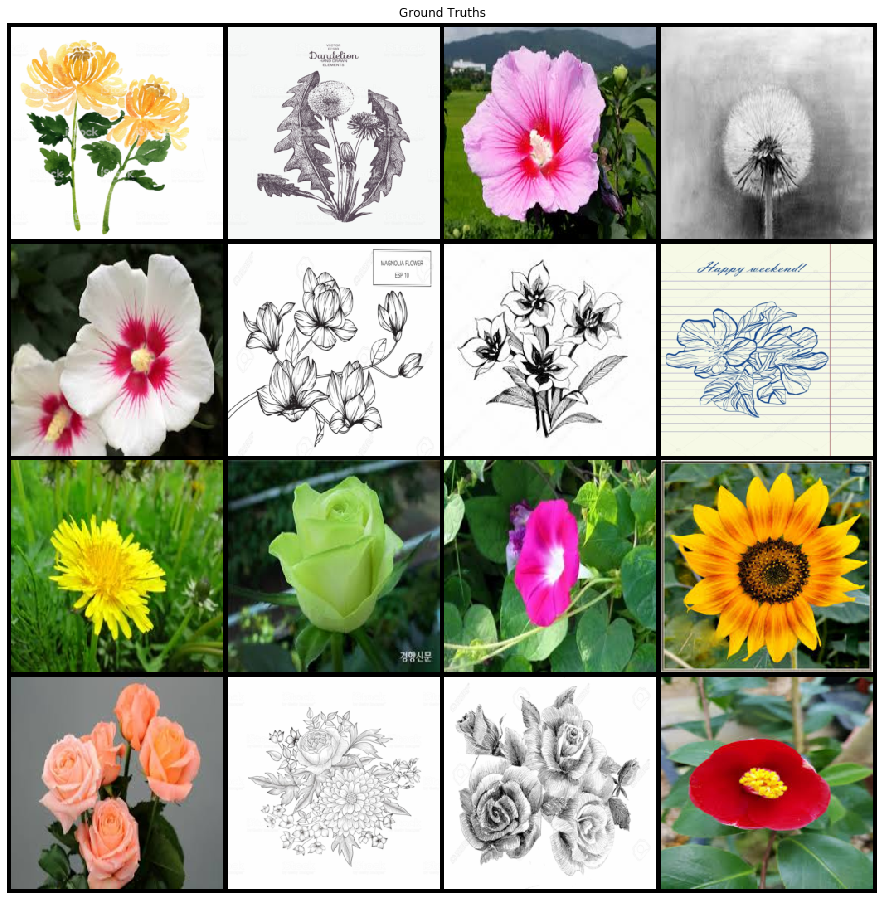

<Figure size 432x288 with 0 Axes>

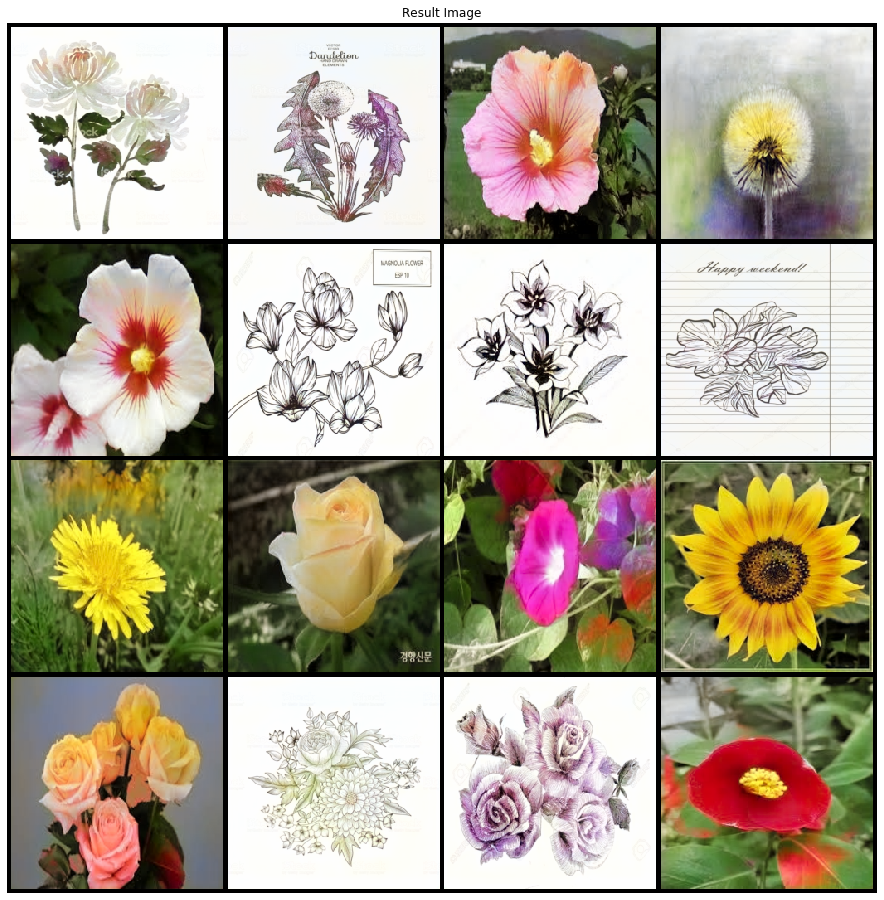

In [17]:
# Plot some training images
test_batch = next(iter(test_loader))
with torch.no_grad():
    
    plt.figure(figsize=(16, 16))
    plt.imshow(vutils.make_grid(to_rgb(test_batch[0], test_batch[1]).to(device)[:16], nrow=4, padding=5, normalize=True).cpu().permute(1,2,0))
    plt.axis("off")
    plt.title("Ground Truths")
    plt.show()

    output_ab = model(test_batch[0].to(device)).detach().to('cpu')
    output = to_rgb(test_batch[0], output_ab)
    #print(output_ab)
    plt.figure(figsize=(16, 16))
    plt.imshow(vutils.make_grid(output[:16], nrow=4, padding=5, normalize=True).cpu().permute(1,2,0))
    plt.axis("off")
    plt.title("Result Image")

    plt.show()

## 5.3 Show the procedure of training

Training 도중에 기록된 Validation 이미지에의 변화를 에니메이션으로 보여줍니다.

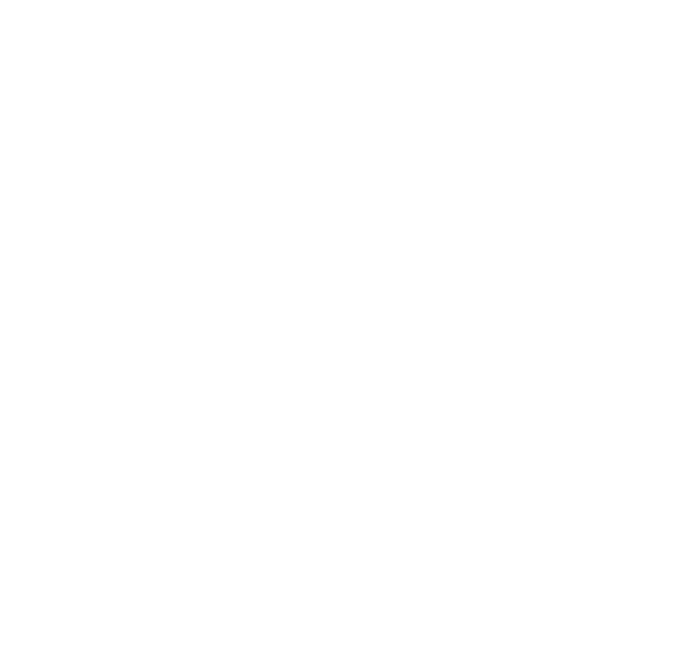

In [18]:
#%%capture
plt.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## **5.4 Plot the losses**

Epoch에 따른 Training Loss, Validation Loss, Learning rate를 출력합니다.

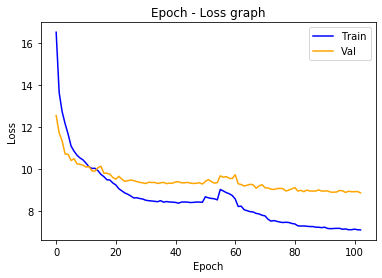

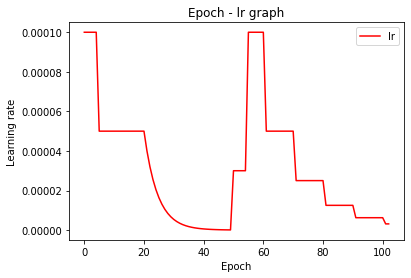

In [19]:
plt.plot(train_loss_list, color = 'blue')
plt.plot(val_loss_list, color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch - Loss graph')
plt.legend(['Train', 'Val'])

plt.show()

plt.plot(lr_list, color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Epoch - lr graph')
plt.legend(['lr'])
plt.show()

# **6. Others**


## 6.1 Initialize record and model

current_epoch, best_losses, model을 초기화합니다.

In [45]:
current_epoch = 0
best_losses = 100000
model = ColorizationNet()
model.to(device)

ColorizationNet(
  (encoder): Encoder(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

In [23]:
train_loss_list = []
val_loss_list = []
lr_list = []
img_list = []

## 6.3 참고자료
[1] Colorful Image Colorization Richard Zhang, Phillip Isola, Alexei A. Efros 
(Submitted on 28 Mar 2016 (v1), last revised 5 Oct 2016 (this version, v5))
https://arxiv.org/abs/1603.08511

[2] Deep Colorization, Zezhou Cheng, Qingxiong Yang, Bin Sheng
(Submitted on 30 Apr 2016)
https://arxiv.org/abs/1605.00075

[3] Auto Colorization of Black and White Images using Machine Learning “Auto-encoders” technique https://medium.com/@mahmoudeljiddawi/auto-colorization-of-black-and-white-images-using-machine-learning-auto-encoders-technique-a213b47f7339